<h2 align="center">Ocean Data Science 2022</h2> 

___

<a href='https://github.com/obidam/ds2-2022'>
<img src="logos.png" alt="drawing" /></a>

___

<h1 align="center">Ocean Warming Contribution to Sea Level Rise</h1> 

<h2 align="center">Joséphine Schmutz, Mario Herrero González</h2> 

<h4 align="center">josephine.schmutz@gmail.com, marioherreroglez34@gmail.com</h4> 

<div style="text-align: right">  
We would like to thank<br>
Sally Close, William Lovel,<br>
Xavier Carton, Bertrand Chapron and Guillaume Maze <br>
for the discussions exchanged and help given. </div>

## Index
0. [Imports and definitions](#imps)
1. [Introduction](#intro)
2. [Global Analysis](#GA)
3. [ADT and Steric Height](#ADT)
5. [Salinity Contribution](#Sal)
6. [Temperature Contribution](#Tem)
7. [Prediction of Steric Height](#pred)
8. [Conclusion](#concl)

<a name='imps'></a>
## Imports and definitions

In [83]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import dask
import gsw
import colmap as cmp
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
from dask import delayed
import pandas as pd
from datetime import date, datetime, time, timedelta
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

import warnings
warnings.simplefilter("ignore")


#Also import basemap cartopy or plotly
from intake import open_catalog
%matplotlib inline
color = cmp.chose_colmap('cb1_r')
#plt.rcParams['figure.figsize'] = (15,8)

Checking for available GPUs,

In [2]:
import torch 
if not torch.cuda.is_available(): print('No GPU available')
else: print('GPU available')

GPU available


In [3]:
def plot_im(variable, title, cbar_title, cbar_size=.08, contourf=False, cmap=color):
    fig = plt.figure(figsize=(25, 15))
    ax = fig.gca(projection=ccrs.Robinson())
    ax.set_title(title)
    ax.gridlines()
    land = ax.add_feature( cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

    if not contourf:
        im = variable.plot( transform=ccrs.PlateCarree(),
                       vmin = variable.min(),vmax=variable.max(),
                       cmap = cmap, add_colorbar=False)
    else:
        im = variable.plot.contourf( transform=ccrs.PlateCarree(),
                       vmin = variable.min(),vmax=variable.max(),
                       cmap = cmap,add_colorbar=False)        

    cb = fig.colorbar(im,fraction=cbar_size,orientation="horizontal",pad=0.025)
    cb.set_label(label=cbar_title, size=32)
    cb.ax.tick_params(labelsize=32)
    #if contourf: cb.ax.tick_params(labelsize=)
    plt.title(title, fontsize=44, pad=24, fontweight='bold')

To use this function just apply as,
```Python
plot_im(variable, 'title', 'cbar_title')
```

In [4]:
def subplot_im(variable, title, cbar_title, axs, cbar_size=.03, contourf=False, cmap=color,vmin=None, vmax=None):
    axs.gridlines()
    land = axs.add_feature(
    cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    if vmin == None: vmin = variable.min()
    if vmax == None: vmax = variable.max()
    if not contourf:
        im = variable.plot(ax=axs, transform=ccrs.PlateCarree(),
                       vmin = vmin, vmax = vmax,
                       cmap = cmap, add_colorbar=False)
    else:
        im = variable.plot.contourf(ax=axs, transform=ccrs.PlateCarree(),
                       vmin = vmin,vmax=vmax,
                       cmap = cmap,add_colorbar=False)        

    cb = fig.colorbar(im,ax=axs,fraction=cbar_size,orientation="horizontal",pad=0.025)
    cb.set_label(label=cbar_title, size=32)
    cb.ax.tick_params(labelsize=32)

    axs.set_title(title, fontsize=44, pad=24, fontweight='bold')

Example on how to use this function:
```Python
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(40,25))
axs = axs.flatten()

subplot_im(variable,'title','cbar_title',axs[0])
subplot_im(variable,'title','cbar_title',axs[1], contourf=True, cbar_size=.08)
subplot_im(variable,'title','cbar_title',axs[3],cmap = 'magma')
subplot_im(variable,'title','cbar_title',axs[2],cbar_size=.08)
```

<a name='intro'></a>
## Introduction


Pangeo is a colective work done by software developers and scientist to enable a better approach towards data science in research. The work done is based on python packages Xarray and Dask, as well as customized environments on cloud and High Performance Computing (HPC) where these tools can be deployed to analyze massive datasets.

*From the official websites:*
1. *Xarray is inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with dask for parallel computing.*

2. *Dask is based on dynamic task scheduling optimized for computation which enables the use of Big Data.*

In oceanography, The Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10 is based on a Gibbs function formulation from which all thermodynamic properties of seawater (density, enthalpy, entropy sound speed, etc.) can be derived in a thermodynamically consistent manner.

The aim of this project is to combine  gsw, xarray and dask python libraries and apply them to a Big Data source in order to study the global steric height and its relationship with the Ocean Heat Content.

From https://podaac-tools.jpl.nasa.gov/drive/files/allData/aviso/L4/dynamic_topo_1deg_1mo/docs/zosTechNote_AVISO_L4_199210-201012.pdf. One sees that the SSH (Sea Surface Height, the measurement of the surface of the ocean that we measure by satellite locally and instantaneously) is the $\Gamma$ + $ADT$ (Absolute dynamic topography). Being $\Gamma$ the geoid: The equipotential surface of the Earth's gravity field which best fits, in a least squares sense, global mean sea level.

<img src="ADT.png" alt="drawing" /></a>

The ADT contains the signatures of the constant currents and the currents which vary with time and that the MSS (Mean sea surface, temporal mean) is the $\Gamma$ + $MDT$ (Mean Dynamic Topography). Therefore,
\begin{equation}
SLA = ADT-MDT 
\end{equation}

The $MDT$ are the constant currents captured at the surface.<br/>
The $SLA$ is the temporal varability of the currents captured at the surface<br/>
<br/>
In the NASA note, https://sealevel.nasa.gov/understanding-sea-level/key-indicators/steric-height. The mean sea level of the oceans raises not solely because of the addition of water in the ocens, for example with the melting of continental galciers, it also raises because the present water in the oceans expand because of thermosteric and halosteric effects. The result of thes two effects (TST and HST) gives the steric change. It will impact the mean height of the ocean waters, therefore the geoid and by consequence the $MSS$
<br/>
The **steric height anomaly** is defined formally by:


> The difference between the height of a given water column and the height of an ideal 0°C, 35 salinity column, where the heights are integrated between specified pressure surfaces.


<a name='GA'></a>
## Global Analysis

- Data Description
- Spatial Analysis
- Temporal Analysis


#### Dataset Description

The dataset here used is the [EN4](https://www.metoffice.gov.uk/hadobs/en4/) dataset that is an interpolation of all available ocean observations (of temperature and salinity) onto a regular space/time grid.

Open dataset:

In [5]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2022/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
ds = cat["en4"].to_dask()

Treat data:
- Select only upto ~2000m

In [6]:
ds = ds.sel(depth=slice(ds.depth[0],ds.depth[30]))

- Pass depth values to negative (positive direction upwards).

In [7]:
ds['depth'] = - ds['depth']

- Pass temperature values to degrees celsius.

In [8]:
ds['temperature'] = ds['temperature'] - 273.15

The variables appearing in the dataset are

In [9]:
print(list(ds.keys()))

['depth_bnds', 'salinity', 'salinity_observation_weights', 'salinity_uncertainty', 'temperature', 'temperature_observation_weights', 'temperature_uncertainty', 'time_bnds']


and dimensions

In [10]:
list(ds.coords)

['depth', 'lat', 'lon', 'time']

In [11]:
%%time
time_mean_SST = ds.temperature.isel(depth=0).mean(dim=['time'])
time_mean_SSS = ds.salinity.isel(depth=0).mean(dim=['time'])                      
time_mean_SST_res, time_mean_SSS_res =dask.compute(time_mean_SST , time_mean_SSS)

CPU times: user 39.3 s, sys: 4.86 s, total: 44.2 s
Wall time: 55 s


In [12]:
%%time
mean_SST = ds.temperature.isel(depth=0).mean(dim=['lon','lat'])
mean_SSS = ds.salinity.isel(depth=0).mean(dim=['lon','lat'])                      
mean_SST_res, mean_SSS_res =dask.compute(mean_SST , mean_SSS)

CPU times: user 37.3 s, sys: 5.23 s, total: 42.6 s
Wall time: 21 s


#### Spatial Description

Plotting the spatial distribution for SST (Sea Surface Temperature) and SSS (Sea Surface Salinity).

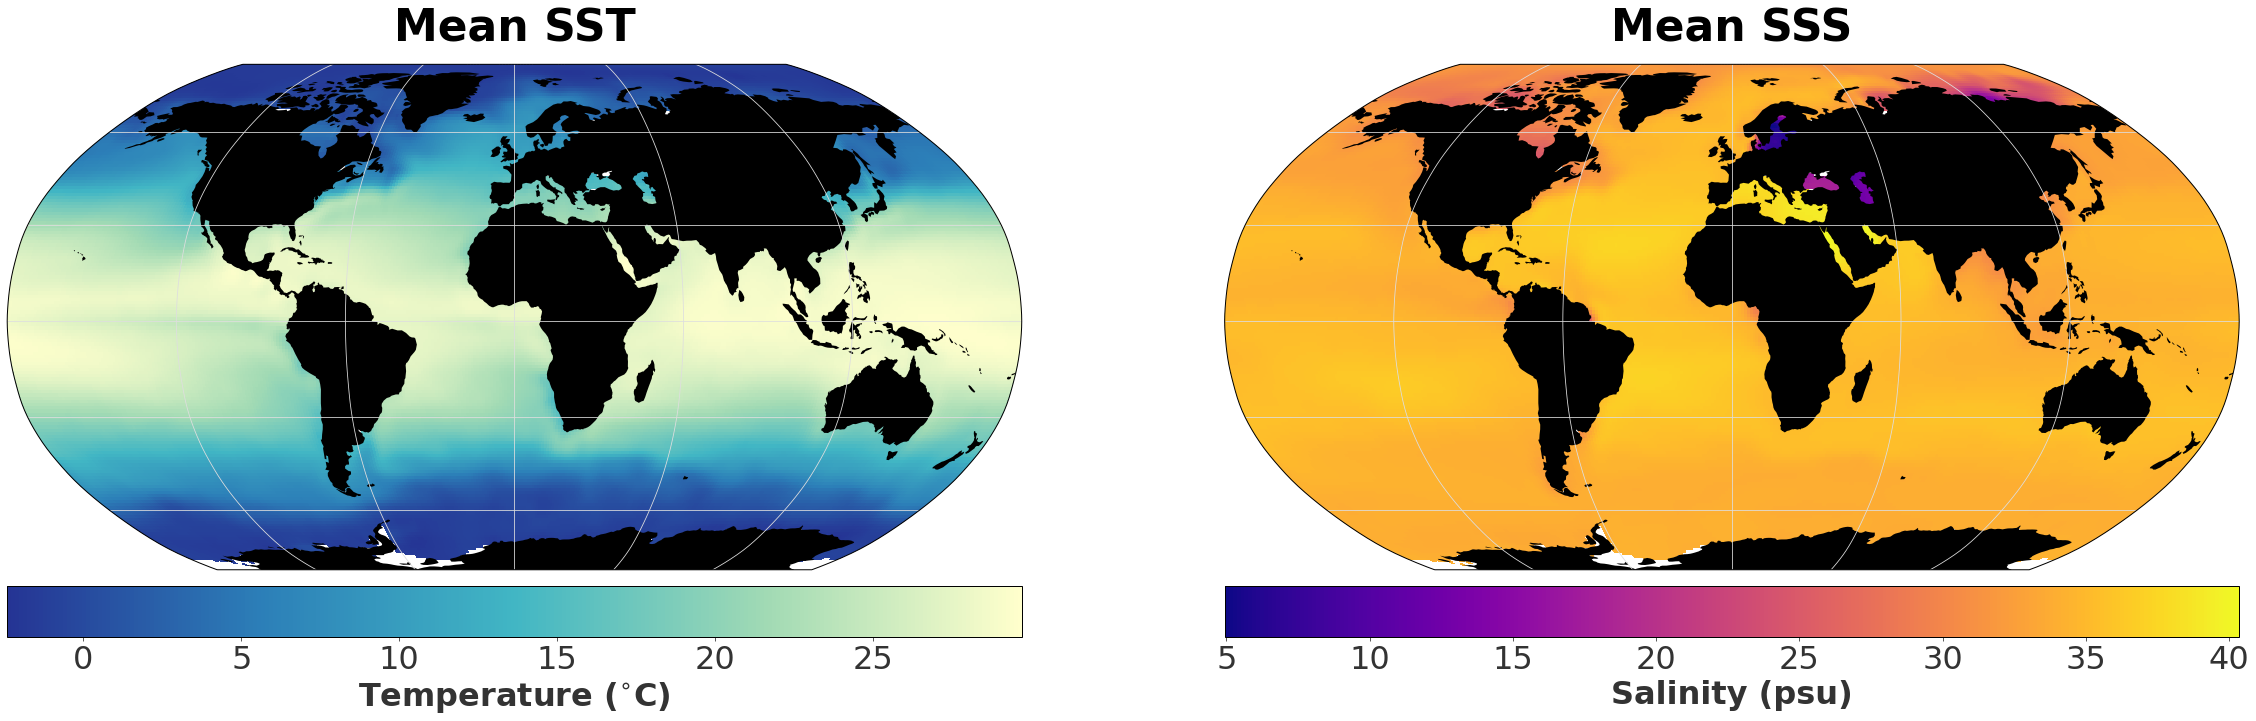

In [13]:
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(40,12))
subplot_im(time_mean_SST_res,"Mean SST",'Temperature ($^{\circ}$C)',axs[0],cbar_size=.08)
subplot_im(time_mean_SSS_res,"Mean SSS",'Salinity (psu)',axs[1],cbar_size=.08,cmap='plasma')

Regarding Mean Sea Surface Temperature (SST), it is observed that the highest temperatures are found near the equator due to solar radiation. Also, differences between east and west boarders are evident for the Atalantic Ocean and Pacific Ocean. 

For the Mean Sea Surface Salinity (SSS) there exists a big contrast between different regions. For example the Mediterranean Sea, 36-40 psu, is almost closed from the Atlantic Ocean, and there is three times more evaporation than there is rain or freshwater flowing into it from rivers. In the Black Sea, the upper layers are generally cooler, less dense and less salty than the deeper waters, as they are fed by large river systems, whereas the deep waters come from the warm, salty waters of the Mediterranean.

#### Temporal Description

Plotting the time series for SST (Sea Surface Temperature) and SSS (Sea Surface Salinity).

In [14]:
reg_SST = stats.linregress(mdates.date2num(ds.time.values), mean_SST_res)
reg_SSS = stats.linregress(mdates.date2num(ds.time.values), mean_SSS_res)

Text(0.5, 1.0, 'Mean SSS')

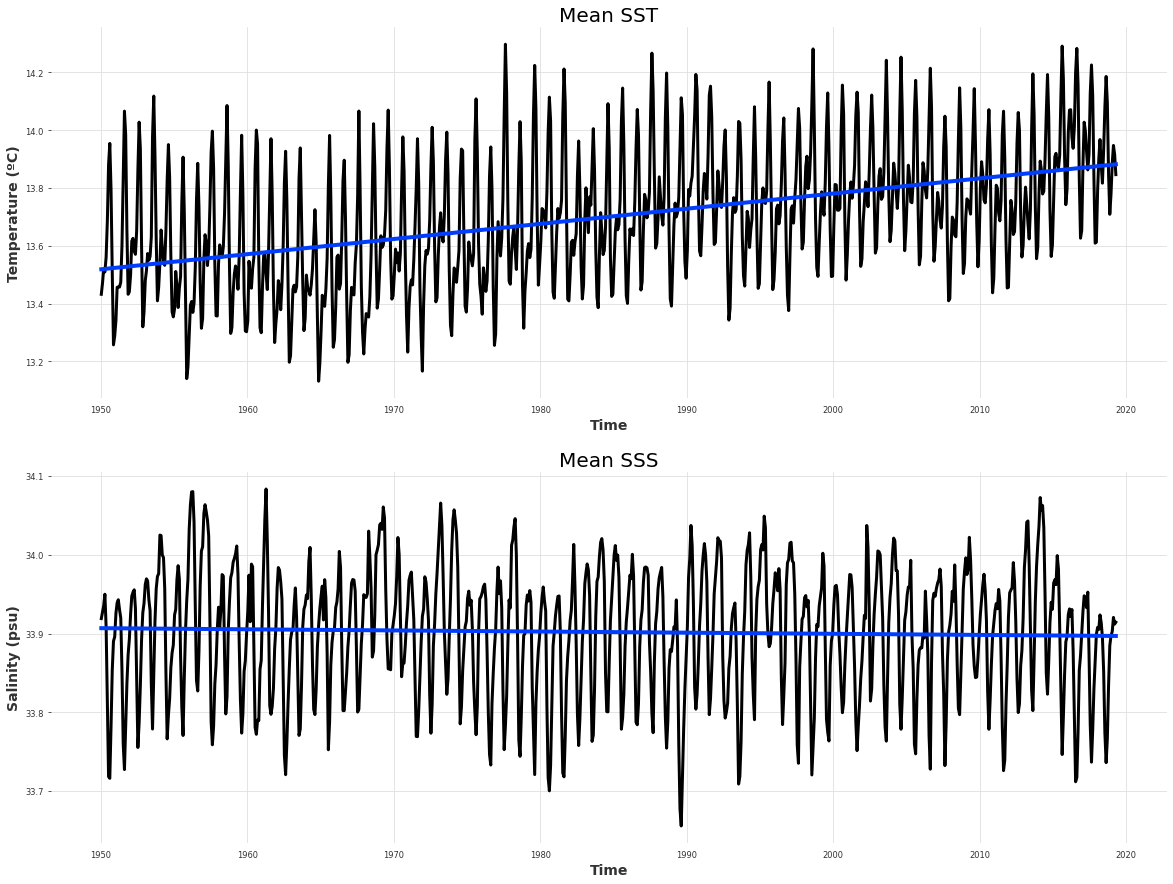

In [15]:
plt.figure(figsize=(20,15))
plt.subplot(211)
plt.plot(ds.time,mean_SST_res,lw=3)
plt.plot(ds.time,reg_SST.intercept + reg_SST.slope*mdates.date2num(ds.time.values),lw=4)
plt.xlabel('Time',fontsize=14)
plt.ylabel('Temperature (ºC)',fontsize=14)
plt.title('Mean SST',fontsize=20)


plt.subplot(212)
plt.plot(ds.time,mean_SSS_res,lw=3)
plt.plot(ds.time,reg_SSS.intercept + reg_SSS.slope*mdates.date2num(ds.time.values),lw=4)
plt.xlabel('Time',fontsize=14)
plt.ylabel('Salinity (psu)',fontsize=14)
plt.title('Mean SSS',fontsize=20)



It is observed that for the SST, there exists an increasing trend whereas for the SSS it is not the case.

#### Sea level data

Sea level data is also accessible in the same catalog,

In [16]:
ds_ssh = cat["sea_surface_height"].to_dask()

with variables,

In [17]:
print(list(ds_ssh.keys()))

['adt', 'crs', 'err', 'lat_bnds', 'lon_bnds', 'sla', 'ugos', 'ugosa', 'vgos', 'vgosa']


and dimensions

In [18]:
list(ds_ssh.coords)

['latitude', 'longitude', 'nv', 'time']

<a name='ADT'></a>
## ADT and Steric Height


In [19]:
condition1 = (ds_ssh.time >= ds_ssh.time[0]) &(ds_ssh.time <= ds_ssh.time[120])
first_mean = ds_ssh['adt'].where(condition1).mean(dim='time').compute()

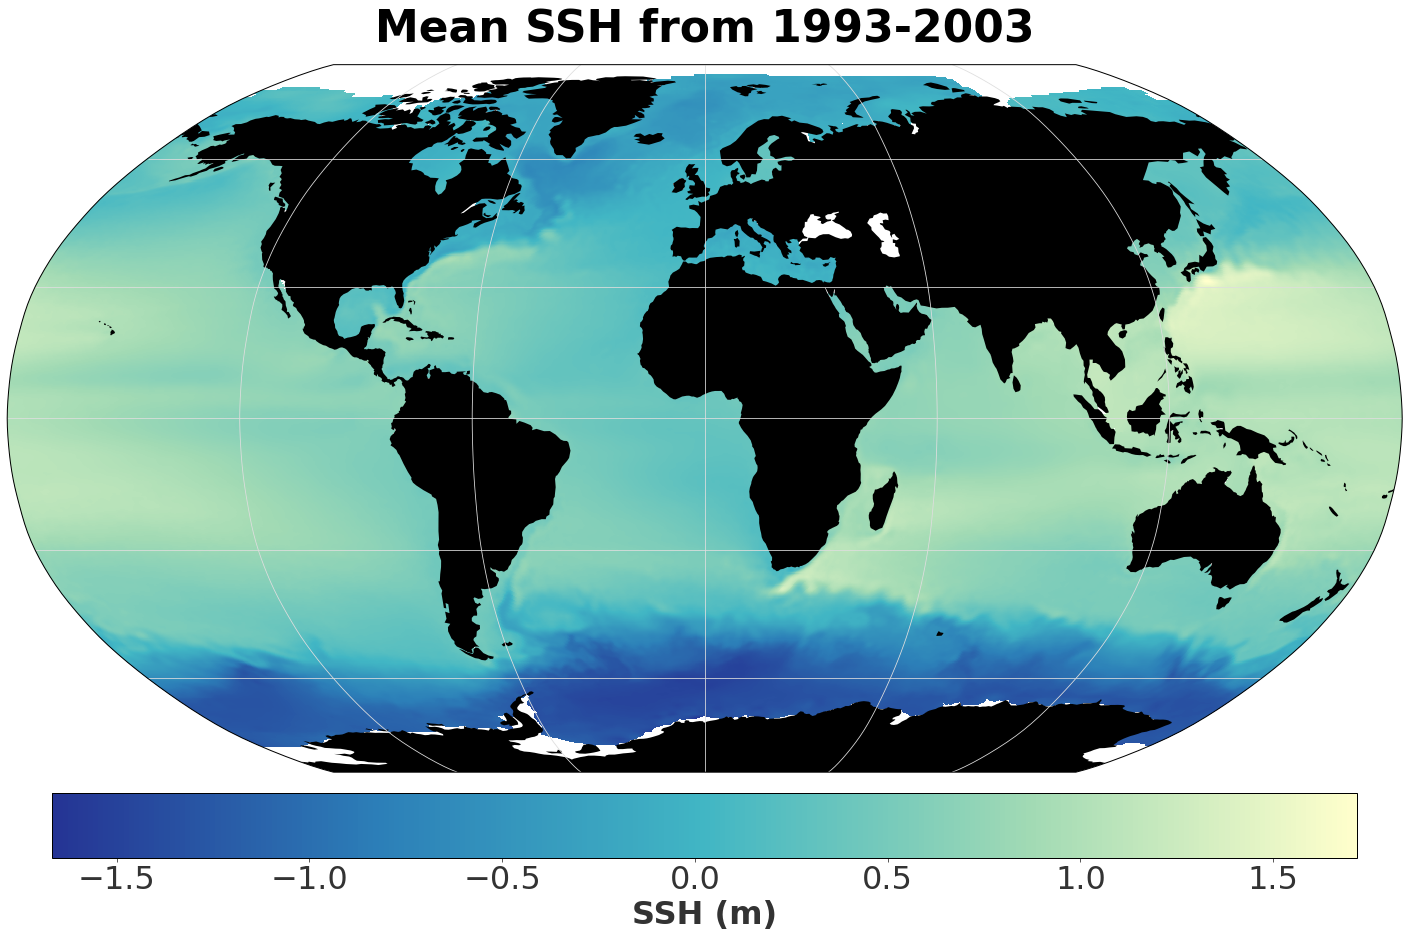

In [20]:
plot_im(first_mean,"Mean SSH from 1993-2003","SSH (m)")

In [21]:
condition2 = (ds_ssh.time >= ds_ssh.time[191]) &(ds_ssh.time <= ds_ssh.time[311])
second_mean = ds_ssh['adt'].where(condition2).mean(dim='time').compute()

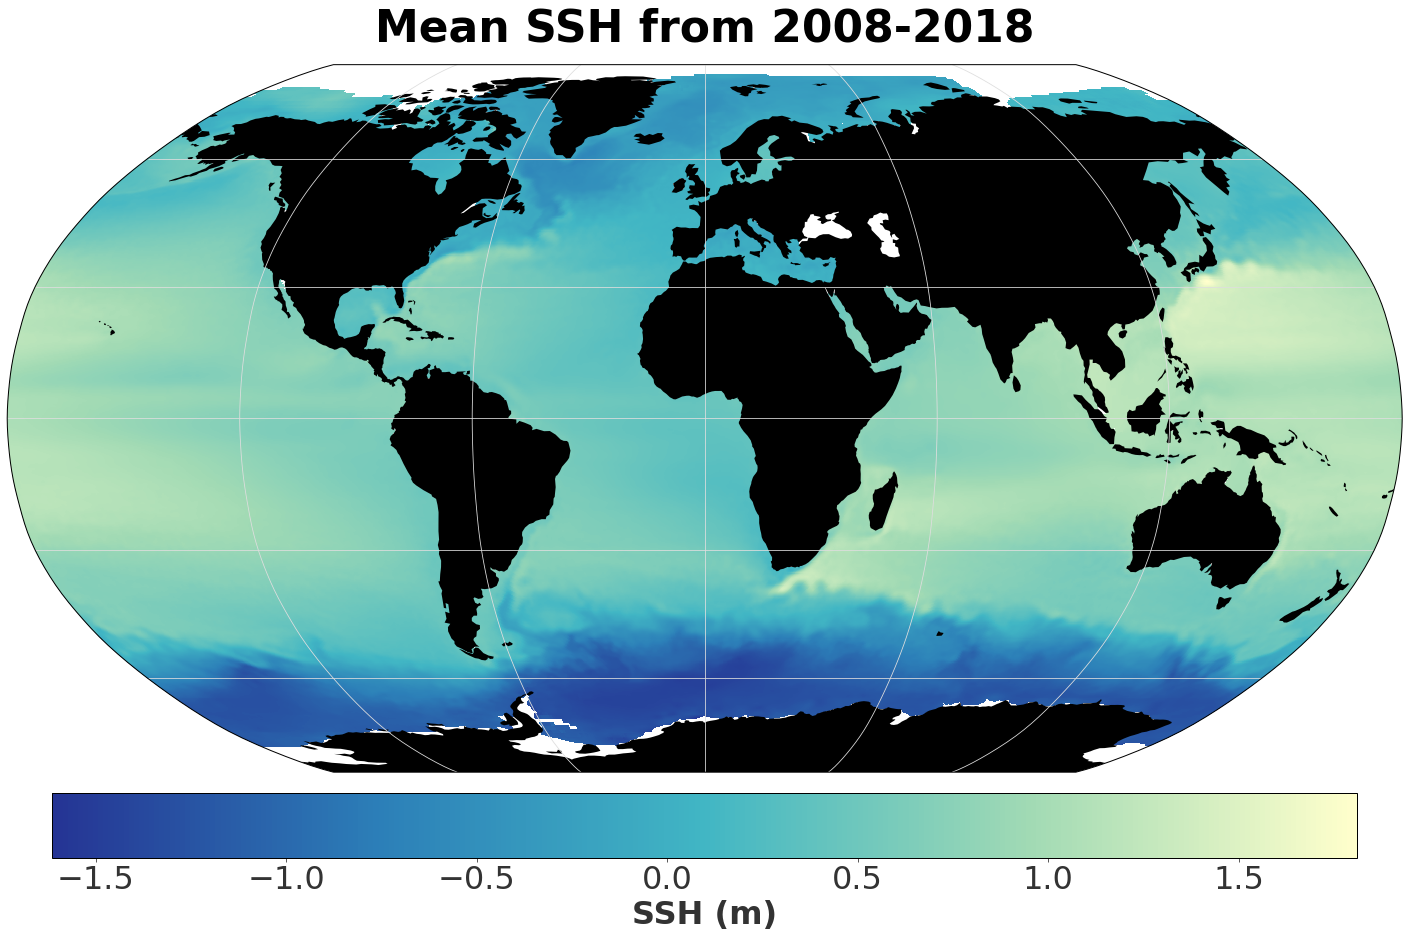

In [22]:
plot_im(second_mean,"Mean SSH from 2008-2018","SSH (m)")

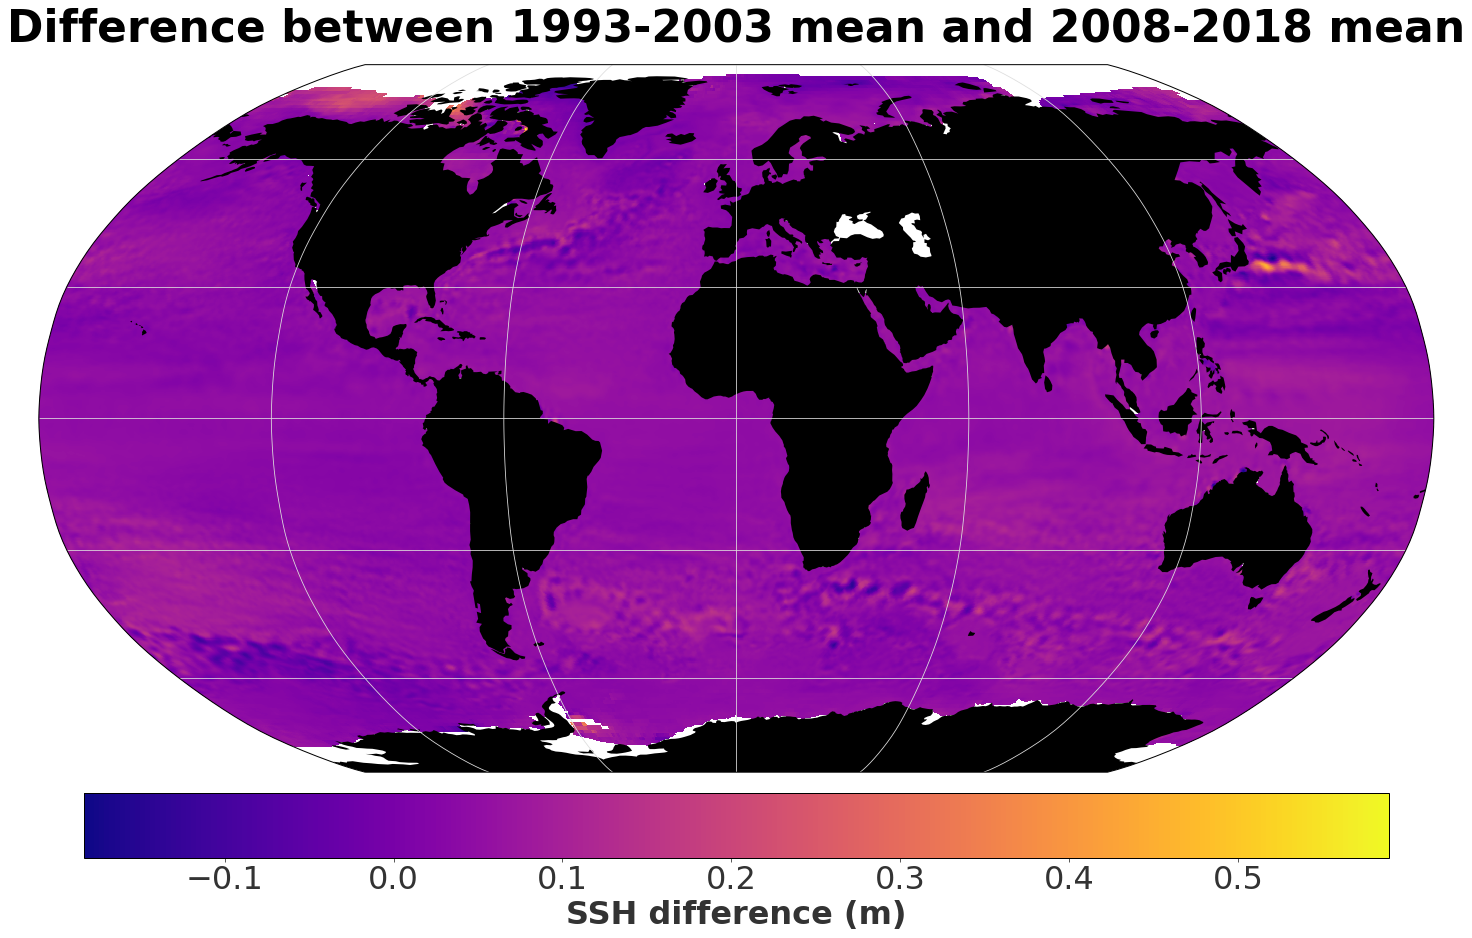

In [23]:
plot_im(second_mean - first_mean, 
        "Difference between 1993-2003 mean and 2008-2018 mean","SSH difference (m)",cmap = "plasma")

In [24]:
(second_mean-first_mean).mean().values

array(0.04834246)

It is observed that the difference between the first period of data 1993-2003 mean and the second period 2008-2018 mean indicates a global raise, in average of 5 cm

Text(0.5, 1.0, 'ADT')

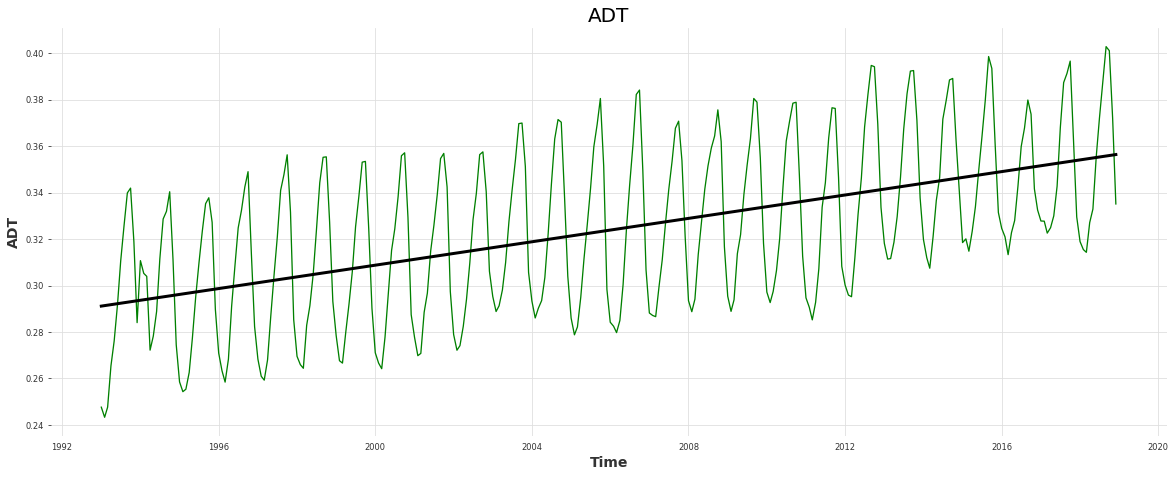

In [25]:
mean_SSH_res = ds_ssh['adt'].mean(dim=('longitude', 'latitude')).compute()
reg_SSH = stats.linregress(mdates.date2num(ds_ssh.time.values), mean_SSH_res)

plt.figure(figsize=(20,7.5))
plt.plot(ds_ssh.time,mean_SSH_res,c ='g')
plt.plot(ds_ssh.time,reg_SSH.intercept + reg_SSH.slope*mdates.date2num(ds_ssh.time.values),lw=3)
plt.xlabel('Time',fontsize=14)
plt.ylabel('ADT',fontsize=14)
plt.title('ADT',fontsize=20)

Averaging by year to eliminate seasonality,

Text(0.5, 1.0, 'ADT')

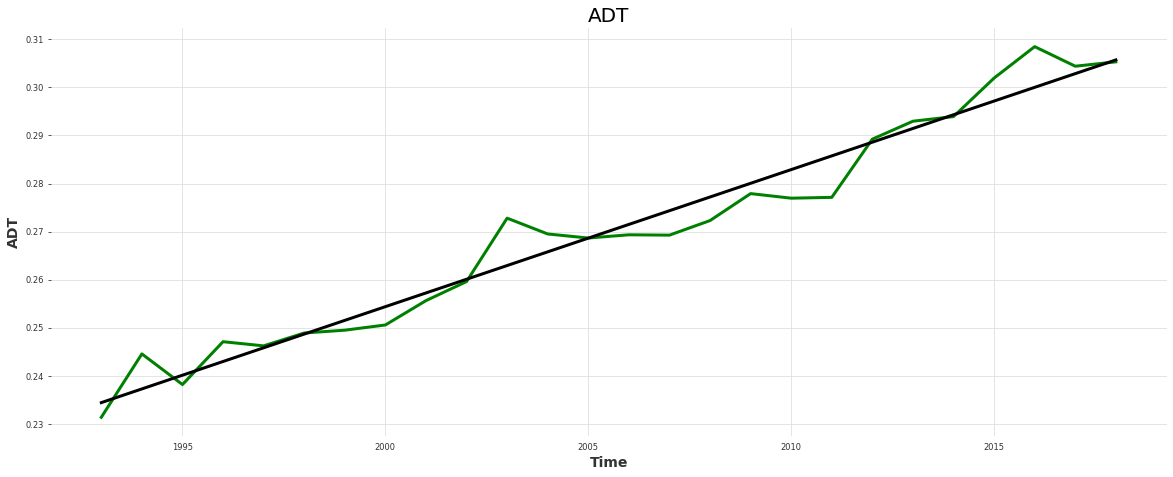

In [26]:
mean_SSH_year = ds_ssh['adt'].groupby('time.year').mean('time').mean(dim=('longitude', 'latitude')).compute()
reg_SSH_year = stats.linregress(mdates.date2num(mean_SSH_year.year.values), mean_SSH_year)

plt.figure(figsize=(20,7.5))
plt.plot(mean_SSH_year.year,mean_SSH_year,c ='g', lw=3)
plt.plot(mean_SSH_year.year,reg_SSH_year.intercept + reg_SSH_year.slope*mdates.date2num(mean_SSH_year.year.values),lw=3)
plt.xlabel('Time',fontsize=14)
plt.ylabel('ADT',fontsize=14)
plt.title('ADT',fontsize=20)

### Steric Height

Calculate pressure values from depth + latitude. <br>
Then make it coincide with Dataset dimensions so it can be applied to other gsw functions:

In [27]:
ds['P'] = xr.apply_ufunc(gsw.p_from_z, ds.depth, ds.lat,
                            dask='parallelized', output_dtypes=[ds.temperature.dtype]).expand_dims({'lon' : ds.lon}).where(
                            ds['temperature'] == ds['temperature'])

Calculate Absolute Salinity and Conservative Temperature (from the metadata it is known that Potential temperature is treated).

In [28]:
ds['SA'] = xr.apply_ufunc(gsw.SA_from_SP,ds.salinity,ds.P,ds.lon,ds.lat,
                            dask='parallelized', output_dtypes=[ds.temperature.dtype])
ds['CT'] = xr.apply_ufunc(gsw.CT_from_pt,ds.SA, ds.temperature,
                         dask='parallelized', output_dtypes=[ds.temperature.dtype])

Average among years. Put pressure dimension axis as first axis for dynamic height.

In [29]:
ds = ds.groupby('time.year').mean('time').transpose('depth', 'year', 'lat', 'lon','bnds')

It is also possible to group every five years but in the following code `time` has to be swapped by `year`.<br>
Uncomment the following line if this is necessary and do the pertinent changes.

In [30]:
#ds = ds.resample(time='5y').mean().transpose('depth', 'time', 'lat', 'lon','bnds')

Apply the dynamic height anomaly parallelized function and divide by the gravity acceleration to obtain steric height anomaly.

In [31]:
g_0 = 9.7963 # m/s^2 
ds['st_height_anom'] =  xr.apply_ufunc( gsw.geo_strf_dyn_height, ds.SA, ds.CT,
                                          ds.P, 2000,dask='parallelized', output_dtypes=[ds.SA.dtype])/g_0

Compute all values together in order to have a more efficient task graph:

In [32]:
%%time
st_height, st_height_sp = da.compute(ds['st_height_anom'].isel(depth=0).mean(dim=('lat','lon')),
                                     ds['st_height_anom'].isel(depth=0).mean(dim=('year')),)

CPU times: user 11min 30s, sys: 23.3 s, total: 11min 53s
Wall time: 7min 20s


**NB:** In this code version, the individual effects of temperature and salinity were not computed as there exists a problem with the code. NANs appear when setting temperature as constant. The code can be reviewed by running the following cell. 

In [33]:
%load steric_height.py

Due to the bathymetry some values remain as NANs and therefor are shown as white pixels. To avoid this from happening it is recommended to change the reference pressure to ~1000 m, however ~2000 m will be kept to be able to compare with NASA data.

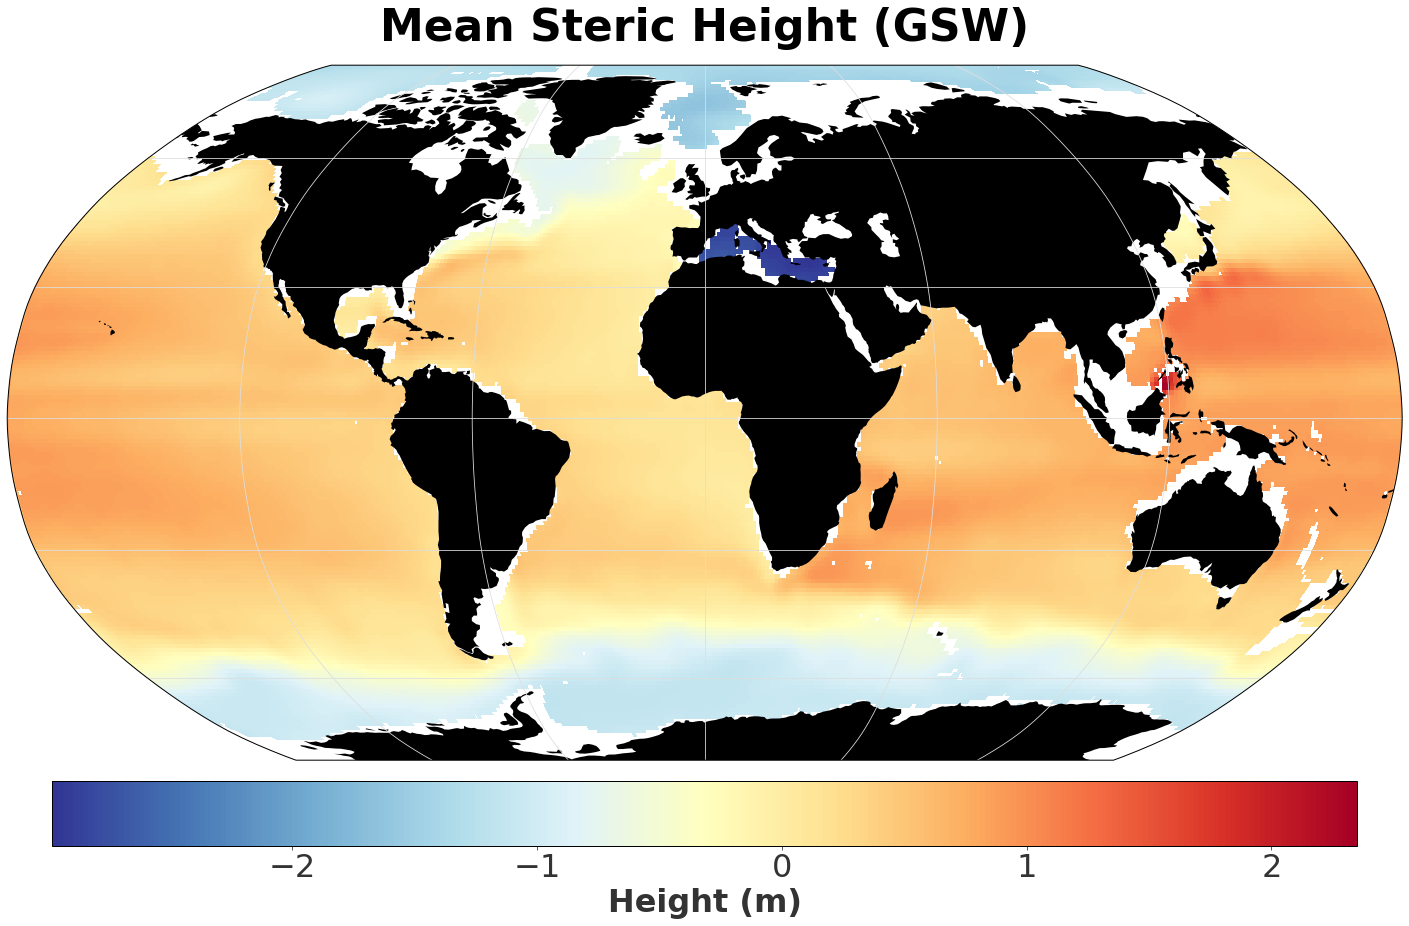

In [34]:
plot_im(st_height_sp-st_height[0],'Mean Steric Height (GSW)', 'Height (m)',cmap='RdYlBu_r')

#### NASA Data - Argofloats

In order to compare acquired data and understand better the thermosteric effect, the time-series from Argofloats available from the NASA webpage is obtained.<br>
Source: https://www.ncei.noaa.gov/access/global-ocean-heat-content/fsl_global.html 

In [35]:
nasa_th = xr.open_dataset('mean_thermosteric_sea_level_anomaly_0-2000_seasonal.nc',
               decode_times=False)

start_date = datetime.strptime('2005-02-14 00:00:00', '%Y-%m-%d %H:%M:%S')
end_date =  datetime.strptime('2021-11-14 00:00:00', '%Y-%m-%d %H:%M:%S')
nasa_th['time'] = pd.date_range(start=start_date, end=end_date, periods=nasa_th.sizes['time'])

In [36]:
nasa = xr.open_dataset('mean_total_steric_sea_level_anomaly_0-2000_yearly.nc',
               decode_times=False)

units, reference_date = nasa.time.attrs['units'].split('since')
reference_date = datetime.strptime(reference_date, ' %Y-%m-%d %H:%M:%S') + timedelta(weeks=(49*52+9))
nasa['time'] = pd.date_range(start=reference_date, periods=nasa.sizes['time'], freq='Y')

In [37]:
nasa_hal = xr.open_dataset('mean_halosteric_sea_level_anomaly_0-2000_yearly.nc',
               decode_times=False)

units, reference_date = nasa_hal.time.attrs['units'].split('since')
reference_date = datetime.strptime(reference_date, ' %Y-%m-%d %H:%M:%S') + timedelta(weeks=(49*52+9))
nasa_hal['time'] = pd.date_range(start=reference_date, periods=nasa_hal.sizes['time'], freq='Y')

Text(0.5, 1.0, 'Evolution of the steric sea level anomaly')

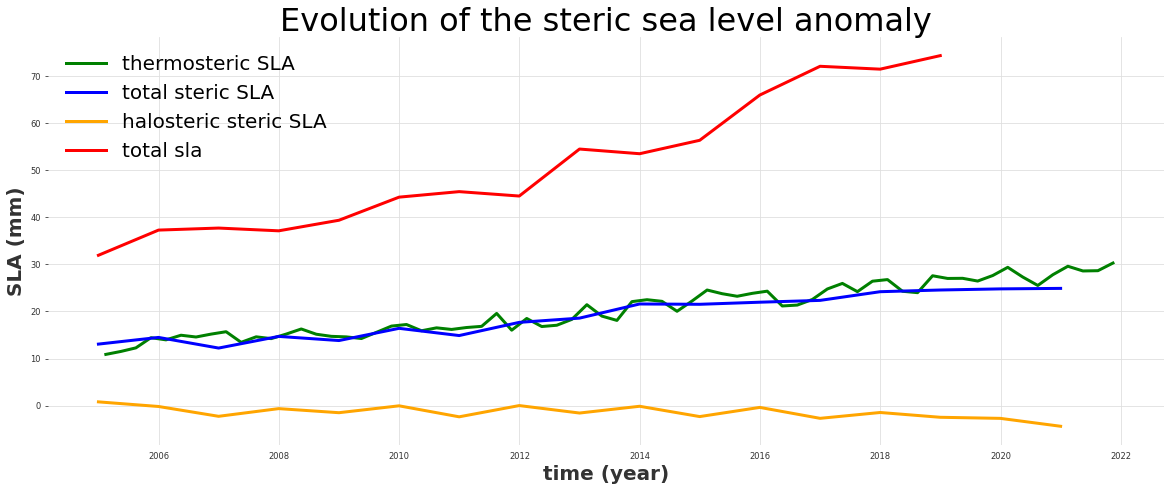

In [38]:
plt.figure(figsize=(20,7.5))
plt.plot(nasa_th.time,nasa_th.a_mm_ts.mean(dim=('lat','lon')),label='thermosteric SLA',color='green',lw=3)
plt.plot(nasa.time,nasa.s_mm_fs.mean(dim=('lat','lon')),label='total steric SLA',color='blue',lw=3)
plt.plot(nasa_hal.time,nasa_hal.b_mm_hs.mean(dim=('lat','lon')),label='halosteric steric SLA',color='orange',lw=3)

sla_y=ds_ssh['sla'].groupby('time.year').mean('time').sel(year=slice(2004, 2018)).mean(dim=('longitude', 'latitude')).values*10**(3)
plt.plot(pd.date_range(start=datetime(2004,1,1,0,0), periods=15, freq='Y'),sla_y,color='red',label='total sla',lw=3)

plt.legend(fontsize=20)
plt.ylabel('SLA (mm)',fontsize=20)
plt.xlabel('time (year)',fontsize=20)
plt.title('Evolution of the steric sea level anomaly',fontsize=32)


In [39]:
model = LinearRegression()
model.fit(np.arange(2004,2021).reshape(-1,1), nasa.s_mm_fs.mean(dim=('lat','lon'))[:,0].values.reshape(-1,1))
y_pred=model.predict(np.arange(2004,2050).reshape(-1,1))

Linear regression with small dataset:

Text(0.5, 1.0, 'Prediction of the total steric height')

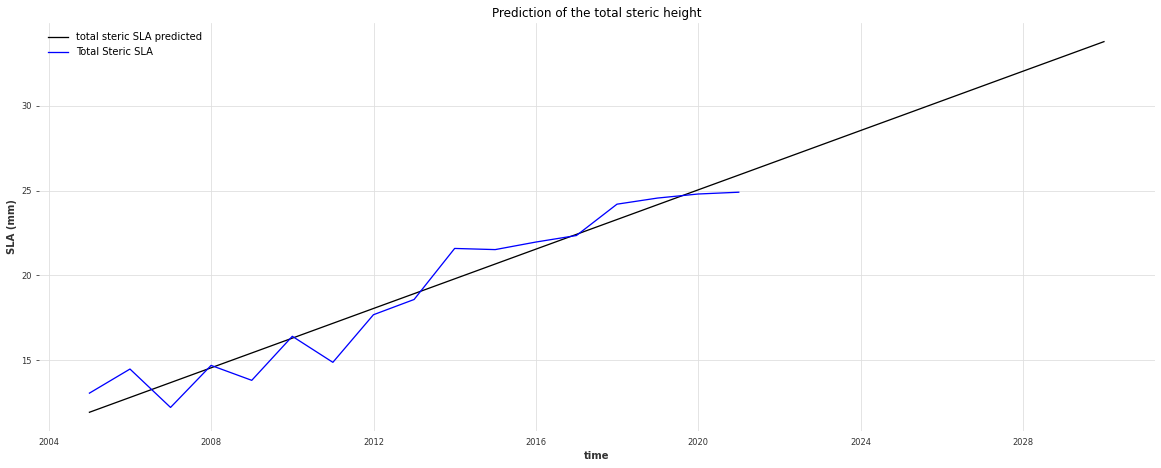

In [40]:
plt.figure(figsize=(20,7.5))
plt.plot(pd.date_range(start=datetime(2004,12,31,0,0), periods=26, freq='Y'),y_pred[:26],color='black',label='total steric SLA predicted')
plt.plot(nasa.time,nasa.s_mm_fs.mean(dim=('lat','lon')),label='Total Steric SLA',color='blue')
plt.legend()
plt.xlabel('time')
plt.ylabel('SLA (mm)')
plt.title('Prediction of the total steric height')


In [41]:
model.coef_

array([[0.87320791]])

In [42]:
model.score(np.arange(2004,2021).reshape(-1,1), nasa.s_mm_fs.mean(dim=('lat','lon'))[:,0].values.reshape(-1,1))

0.938106952571255

#### Comparison calculated with observed model

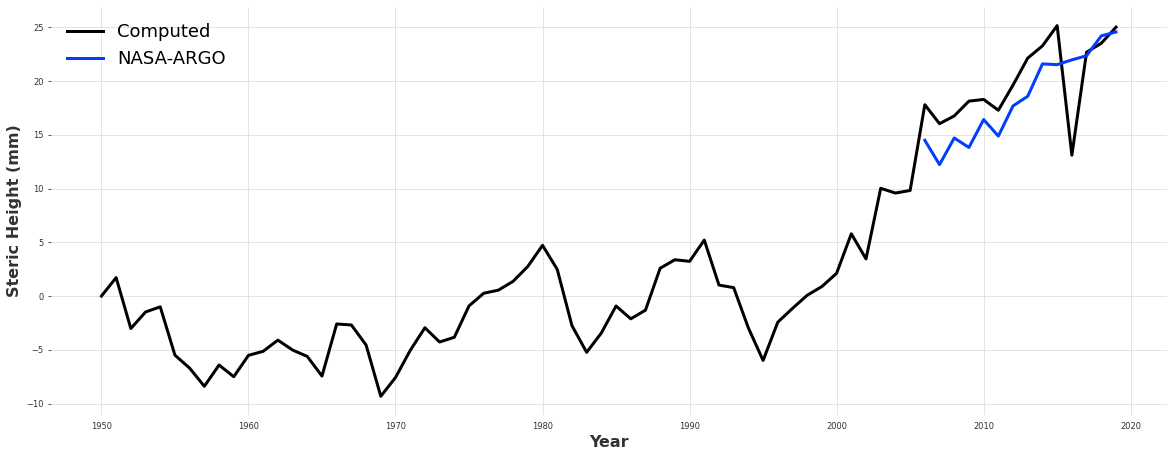

In [43]:
plt.rcParams['figure.figsize'] = (20,7.5)
plt.plot(st_height.year, (st_height-st_height[0])*1000, lw = 3, label='Computed')
plt.plot(st_height.year[-14:],nasa.s_mm_fs.mean(dim=('lat','lon')).values.reshape(17)[1:-2],lw=3,label='NASA-ARGO')
plt.xlabel('Year',fontsize=16)
plt.ylabel('Steric Height (mm)',fontsize=16)
plt.legend(fontsize=18)

## Ocean Heat Content, OHC

Ocean total surface

In [44]:
oc_surf = 3.61e14 #m**2

In [45]:
ds_ohc = cat["en4"].to_dask()
ds_ohc = ds_ohc.sel(depth=slice(ds_ohc.depth[0],ds_ohc.depth[31]))
ds_ohc['depth'] = - ds_ohc['depth']
ds_ohc['temperature'] = ds_ohc['temperature'] - 273.15

In [46]:
# cp and rho
rho  = 1035 #kg/m^3
cp = 4.1855 #Joules

In [47]:
# compute dz
ds_ohc['dz'] = ds_ohc.depth_bnds.isel(time=0).diff('bnds').squeeze('bnds')

In [48]:
# average the temperature per year 
temp_y = ds_ohc.temperature.groupby('time.year').mean('time')
## compute Q 
integral_Q = ((ds_ohc.dz*temp_y*cp*rho*oc_surf).sum('depth'))
%time Q = integral_Q.compute()

CPU times: user 45.8 s, sys: 4.35 s, total: 50.1 s
Wall time: 14.1 s


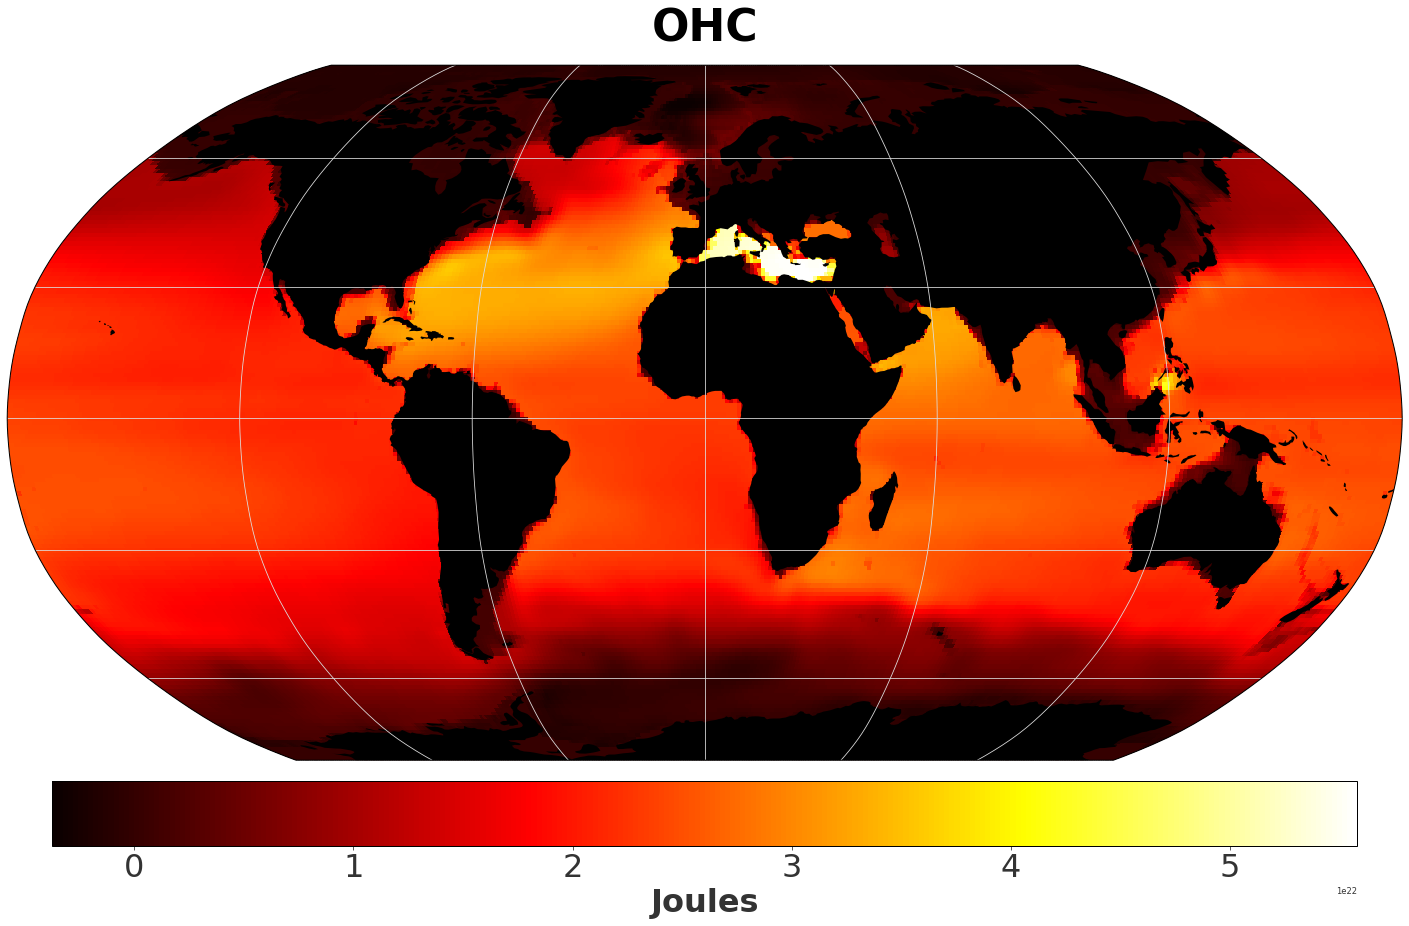

In [49]:
plot_im(Q.mean('year'),"OHC", "Joules",cmap='hot')

In [50]:
nasa_ohc = xr.open_dataset('heat_content_anomaly_0-2000_yearly.nc',
               decode_times=False)

units, reference_date = nasa_ohc.time.attrs['units'].split('since')
reference_date = datetime.strptime(reference_date, ' %Y-%m-%d %H:%M:%S') + timedelta(weeks=(49*52+9))
nasa_ohc['time'] = pd.date_range(start=reference_date, periods=nasa.sizes['time'], freq='Y')

In [51]:
nasa_ohc.h18_hc

<xarray.DataArray 'h18_hc' (time: 17, depth: 1, lat: 180, lon: 360)>
[1101600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 2004-12-31 2005-12-31 ... 2020-12-31
Dimensions without coordinates: depth
Attributes:
    long_name:     Ocean heat content anomaly calculated from objectively ana...
    coordinates:   time lat lon depth
    cell_methods:  area: mean depth: mean time: mean
    grid_mapping:  crs
    units:         10^18_joules

<a name='Sal'></a>
## Comparison between OHC and Steric Height

As it has been seen steric height is due to both thermosteric and halosteric effects so that heat only will not account for all the steric effect of the ocean. Let the effect of salt be neglected

Then, take a volume $V_0= S \cdot h_0$ of pure water at temperature $T_0$ and of mass $M$ ($S$ horizontal area fixed, $h_0$ height).The equation of state is (assuming a fluid not too deep),
\begin{equation}
\rho = \rho_0[ 1 - \alpha (T - T_0)]
\end{equation}
neglecting salt (and pressure) effects.

Mass is conserved. so when water is heated up to temperature $T$,density decreases from $\rho_0$ to $\rho$, and so the volume $V$ must increase
and so must $h$
\begin{equation}
M = S h \rho = S h_0 \rho_0 \implies h = \frac{h_0 }{ 1 - \alpha (T - T_0) }
\end{equation}

Now the heat content of the fluid is $Q = \int dV \rho c_p T$ ($c_p$ heat capacity of water) assuming $T$ uniform in the volume, that is $Q = M c_p T$

so
\begin{equation}
h = \frac{c_p h_0}{ c_p- \alpha (Q - Q_0)}
\end{equation}

This means both variables should be correlated.<br> *The time period of interest is reduced to the last 20 years of the available data:*

In [52]:
%%time
corr = xr.corr(integral_Q.sel(year=slice(2017, 2018)),ds['st_height_anom'].isel(depth=0).sel(year=slice(2017, 2018)),dim='year').compute()

CPU times: user 42.3 s, sys: 1.51 s, total: 43.8 s
Wall time: 26.6 s


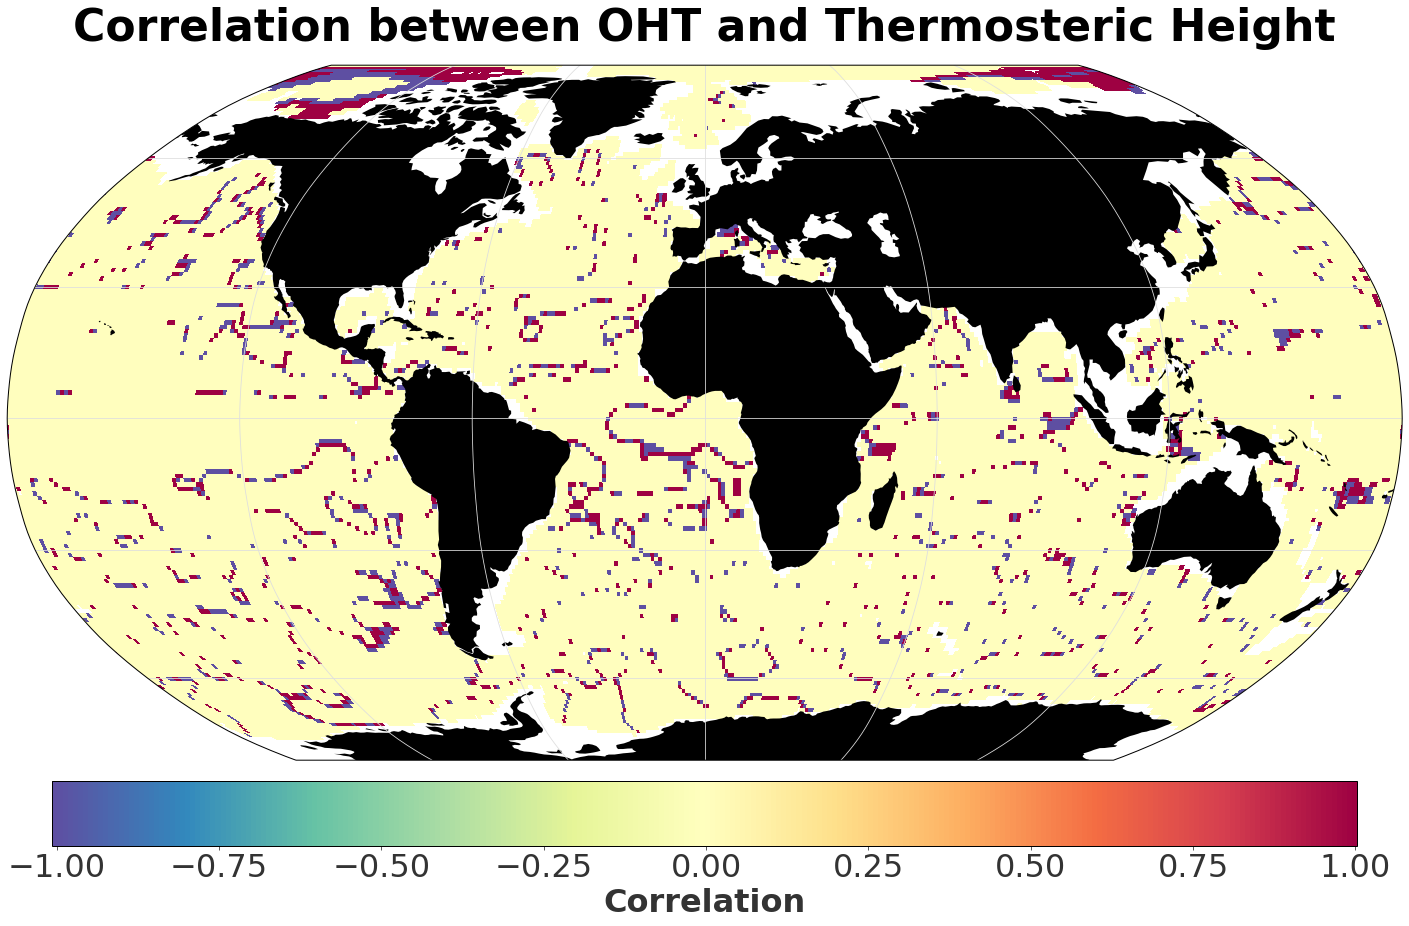

In [53]:
plot_im(corr,"Correlation between OHT and Thermosteric Height","Correlation",cmap='Spectral_r')

Correlation may be lost due to the averages before created, this needs to be assessed adequately.